## Importing Packages & Loading the Data

In [3]:
#importing packages

import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

import folium

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#!pip install fbprophet

In [5]:
#read in all datasets

#median rent asking price for studio, 1br and 3br+
rent_studio = pd.read_csv('csvs/medianAskingRent_Studio.csv')
rent_1br = pd.read_csv('csvs/medianAskingRent_OneBd.csv')
rent_3br_plus = pd.read_csv('csvs/medianAskingRent_ThreePlusBd.csv')

#inventory for studio, 1br and 3br+
inv_studio = pd.read_csv('csvs/rentalInventory_Studio.csv')
inv_1br = pd.read_csv('csvs/rentalInventory_OneBd.csv')
inv_3br_plus = pd.read_csv('csvs/rentalInventory_ThreePlusBd.csv')

In [6]:
#We'll be using rent data from 2015 to May 2020

#rent_studio.head(3)

In [7]:
#transpose dataset, rename columns, change index to datetime object

#studio
studio_df = rent_studio.T
studio_df.columns = rent_studio.iloc[:,0]
studio_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
studio_df.index = pd.to_datetime(studio_df.index)

#1br
onebr_df = rent_1br.T
onebr_df.columns = rent_1br.iloc[:,0]
onebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
onebr_df.index = pd.to_datetime(onebr_df.index)

#3br+
threebr_df = rent_3br_plus.T
threebr_df.columns = rent_3br_plus.iloc[:,0]
threebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
threebr_df.index = pd.to_datetime(threebr_df.index)

Neighborhoods:

- Astoria
- Greenpoint
- Woodside

In [8]:
#filter dataframes | we only want 2015-2020 rental data of the three neighborhoods mentioned above

agw_studios = studio_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_1br = onebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_3br = threebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]

## Sunnyside

In [9]:
sunnyside_map = folium.Map(location=[40.7433, -73.9196], zoom_start=15)

In [10]:
sunnyside_map

### Studios

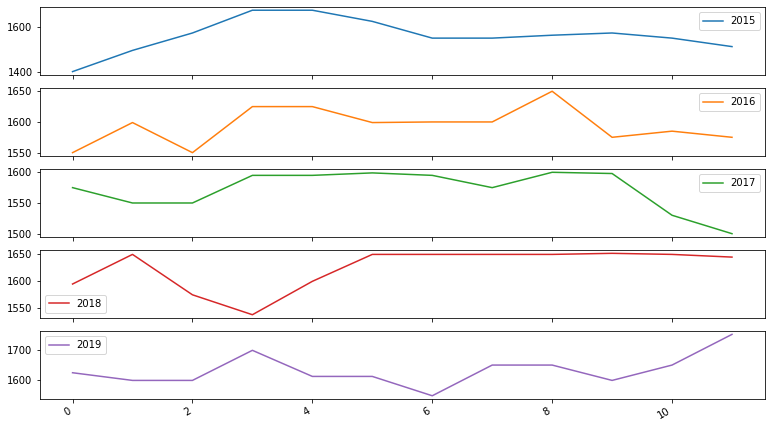

In [11]:
# Use pandas grouper to group values using annual frequency
year_groups_s = agw_studios['2015':'2019'][['Sunnyside']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
studios_annual_s = pd.DataFrame()

for yr, group in year_groups_s:
    studios_annual_s[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
studios_annual_s.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [12]:
roll_mean_s = agw_studios[['Sunnyside']].rolling(window=8, center=False).mean()
roll_std_s = agw_studios[['Sunnyside']].rolling(window=8, center=False).std()

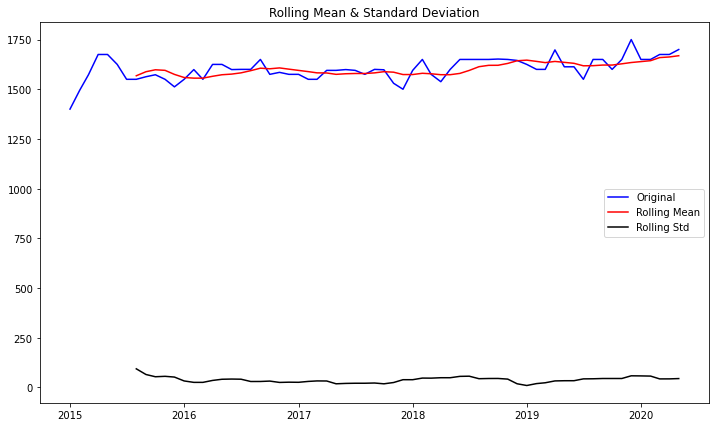

In [13]:
fig = plt.figure(figsize=(12,7))
plt.plot(agw_studios[['Sunnyside']], color='blue', label='Original')
plt.plot(roll_mean_s, color='red', label='Rolling Mean')
plt.plot(roll_std_s, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [14]:
#dickeyfuller test for Sunnyside Studios

dftest_s = adfuller(agw_studios[['Sunnyside']])

# Extract and display test results in a user friendly manner
dfoutput_s = pd.Series(dftest_s[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_s[4].items():
    dfoutput_s['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_s)

Results of Dickey-Fuller test: 

Test Statistic                 -1.796457
p-value                         0.382222
#Lags Used                      3.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


### ACF & PACF

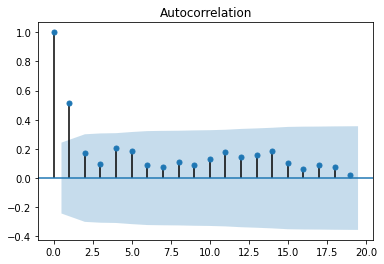

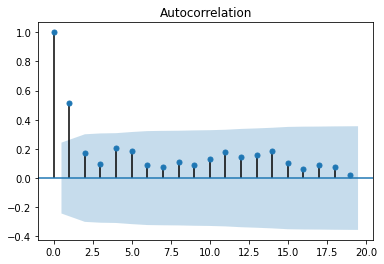

In [15]:
plot_acf(agw_studios['Sunnyside'])

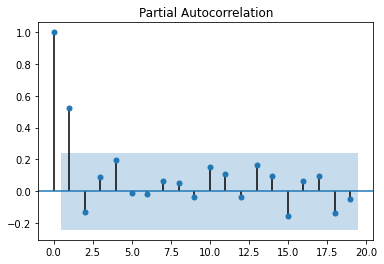

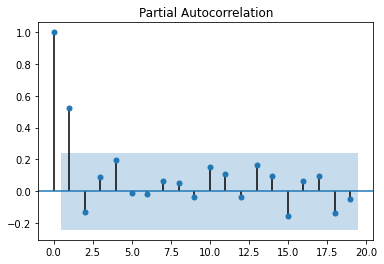

In [16]:
plot_pacf(agw_studios['Sunnyside'])

## BASELINE MODEL

In [17]:
#Base

sunnyside_studios = agw_studios[['Sunnyside']]

In [18]:
# Create lagged dataset
values = pd.DataFrame(sunnyside_studios.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

    t-1   t+1
0   NaN  1400
1  1400  1495
2  1495  1573
3  1573  1675
4  1675  1675


In [19]:
# split into train and test sets
X_base = dataframe.values
train_size = int(len(X_base) * 0.75)
train, test = X_base[1:train_size], X_base[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [20]:
# persistence model
def model_persistence(x):
    return x

In [21]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 58.447


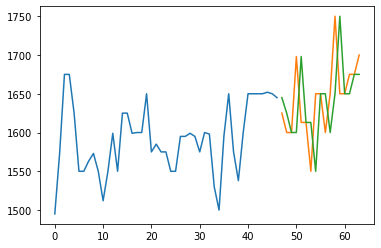

In [22]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

## ARIMA MODEL

predicted=1644.137801, expected=1625.000000
predicted=1630.442473, expected=1600.000000
predicted=1612.756136, expected=1600.000000
predicted=1612.162880, expected=1698.000000
predicted=1680.234258, expected=1613.000000
predicted=1625.176767, expected=1613.000000
predicted=1624.236681, expected=1550.000000
predicted=1583.296164, expected=1650.000000
predicted=1644.291541, expected=1650.000000
predicted=1646.361572, expected=1600.000000
predicted=1617.909871, expected=1650.000000
predicted=1646.009505, expected=1750.000000
predicted=1707.814962, expected=1650.000000
predicted=1651.675672, expected=1650.000000
predicted=1651.729463, expected=1675.000000
predicted=1665.981902, expected=1675.000000
predicted=1667.706261, expected=1700.000000
Test RMSE: 49.994


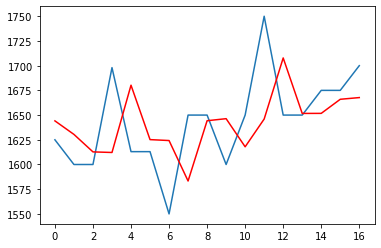

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   63
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -327.370
Method:                       css-mle   S.D. of innovations             42.638
Date:                Sun, 28 Jun 2020   AIC                            662.741
Time:                        11:04:40   BIC                            671.313
Sample:                             1   HQIC                           666.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8326      0.556      3.298      0.001       0.743       2.922
ar.L1.D.y      0.4929      0.127      3.880      0.000       0.244       0.742
ma.L1.D.y     -1.0000      0.043    -23.101      0.0

In [39]:
#ARIMA model

X_rima = agw_studios[['Sunnyside']].values
size = int(len(X_rima) * 0.75)
train, test = X_rima[0:size], X_rima[size:len(X_rima)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
print(model_fit.summary())

## FB PROPHET

In [25]:
fb_sunny = sunnyside_studios

In [26]:
fb_sunny.reset_index(inplace=True)
fb_sunny.index.rename('', inplace=True)
fb_sunny.rename(columns={'index': 'ds', 'Sunnyside': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [27]:
fb_sunny.head()

areaName,ds,y
,,
0,2015-01-01,1400
1,2015-02-01,1495
2,2015-03-01,1573
3,2015-04-01,1675
4,2015-05-01,1675


In [28]:
# Train/Split

X_s_studios = fb_sunny['ds'].values
y_s_studios = fb_sunny['y'].values

X_train = X_s_studios[:int(X_s_studios.shape[0]*0.75)]
X_test = X_s_studios[int(X_s_studios.shape[0]*0.75):]
y_train = y_s_studios[:int(X_s_studios.shape[0]*0.75)]
y_test = y_s_studios[int(X_s_studios.shape[0]*0.75):]

sun_studio_train = pd.DataFrame(y_train,index = X_train, columns = ['y'])
sun_studio_test = pd.DataFrame(y_test, index = X_test, columns = ['y'])
sun_studio_train.head()
sun_studio_train.reset_index(inplace = True)
sun_studio_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  60.513276049148885


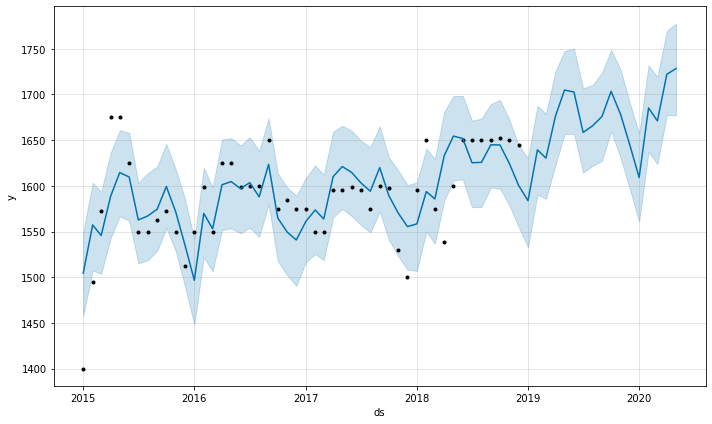

In [29]:
sun_studios_prophet = Prophet().fit(sun_studio_train)

future_sun_studios = sun_studios_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_sun_studios = sun_studios_prophet.predict(future_sun_studios)
forecast_sun_studios.tail()

fig1_sun_studios = sun_studios_prophet.plot(forecast_sun_studios)

preds_sun_studios = forecast_sun_studios[48:][['ds','yhat']].set_index('ds')
preds_sun_studios.head()

preds_sun_studios_df = pd.concat([sun_studio_test ,preds_sun_studios],axis = 1)
preds_sun_studios_df.head()

error = np.sqrt(sum((preds_sun_studios_df['y'] - preds_sun_studios_df['yhat'])**2)/len(preds_sun_studios_df))
print('RMSE in $$: ', error)

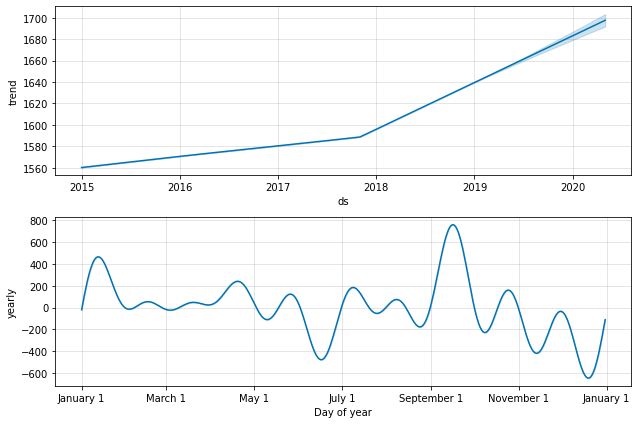

In [30]:
fig2_sun_studios = sun_studios_prophet.plot_components(forecast_sun_studios)

### One Bedroom Aparments

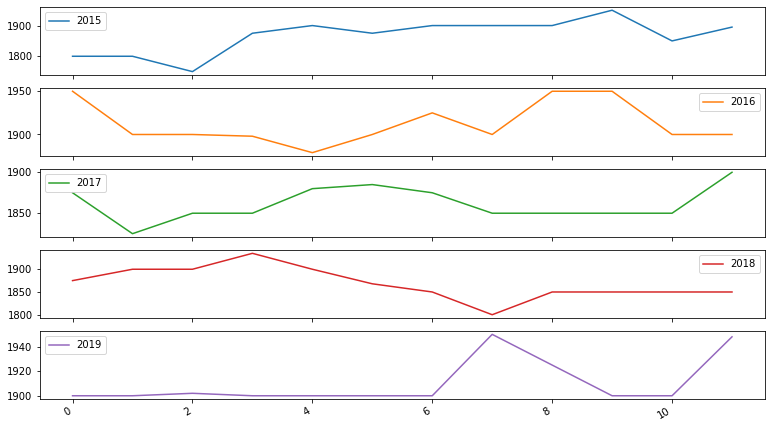

In [33]:
# Use pandas grouper to group values using annual frequency
year_groups_s_1br = agw_1br['2015':'2019'][['Sunnyside']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
annual_s_1br = pd.DataFrame()

for yr, group in year_groups_s_1br:
    annual_s_1br[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
annual_s_1br.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [34]:
roll_mean_s_1br = agw_1br[['Sunnyside']].rolling(window=8, center=False).mean()
roll_std_s_1br = agw_1br[['Sunnyside']].rolling(window=8, center=False).std()

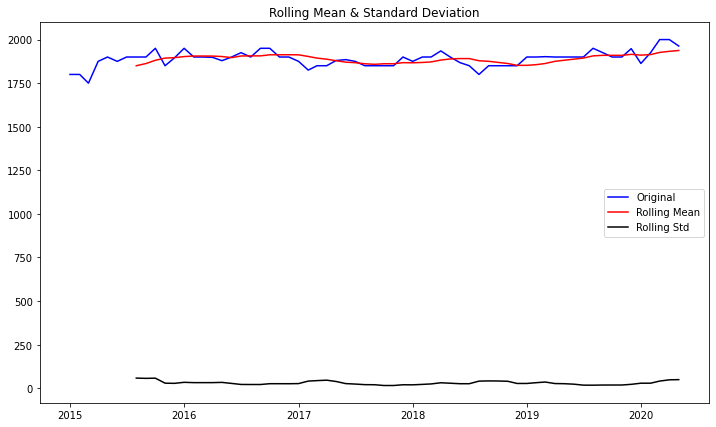

In [35]:
fig_roll_1br = plt.figure(figsize=(12,7))
plt.plot(agw_1br[['Sunnyside']], color='blue', label='Original')
plt.plot(roll_mean_s_1br, color='red', label='Rolling Mean')
plt.plot(roll_std_s_1br, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [36]:
#dickeyfuller test for Astoria Studios

dftest_s_1br = adfuller(agw_1br[['Sunnyside']])

# Extract and display test results in a user friendly manner
dfoutput_s_1br = pd.Series(dftest_s_1br[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_s_1br[4].items():
    dfoutput_s_1br['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_s_1br)

Results of Dickey-Fuller test: 

Test Statistic                 -3.879399
p-value                         0.002192
#Lags Used                      0.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


### ACF & PACF

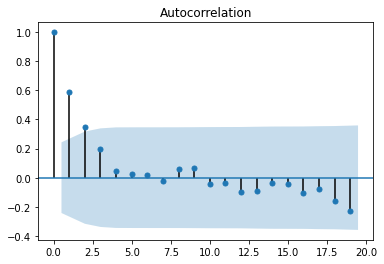

In [37]:
plot_acf(agw_1br['Sunnyside']);

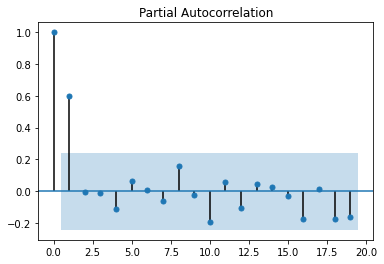

In [38]:
plot_pacf(agw_1br['Sunnyside']);

### BASELINE MODEL

In [41]:
sunny_1br = agw_1br[['Sunnyside']]

In [42]:
# Create lagged dataset
values_1br = pd.DataFrame(sunny_1br.values)
dataframe_1br = pd.concat([values_1br.shift(1), values_1br], axis=1)
dataframe_1br.columns = ['t-1', 't+1']
print(dataframe_1br.head(5))

    t-1   t+1
0   NaN  1800
1  1800  1800
2  1800  1750
3  1750  1875
4  1875  1900


In [43]:
# split into train and test sets
X_1br = dataframe_1br.values
train_size_1br = int(len(X_1br) * 0.75)
train_1br, test_1br = X_1br[1:train_size_1br], X_1br[train_size_1br:]
train_X_1br, train_y_1br = train_1br[:,0], train_1br[:,1]
test_X_1br, test_y_1br = test_1br[:,0], test_1br[:,1]

In [44]:
#model persistence defined above in studios

# walk-forward validation
predictions_1br = list()
for x in test_X_1br:
    yhat_1br = model_persistence(x)
    predictions_1br.append(yhat_1br)
test_score = mean_squared_error(test_y_1br, predictions_1br)
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 39.575


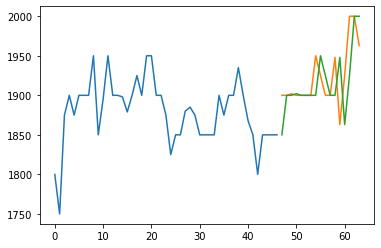

In [45]:
# plot predictions and expected results
plt.plot(train_y_1br)
plt.plot([None for i in train_y_1br] + [x for x in test_y_1br])
plt.plot([None for i in train_y_1br] + [x for x in predictions_1br])
plt.show()

### ARIMA MODEL

predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1902.000000
predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1950.000000
predicted=1859.044025, expected=1925.000000
predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1900.000000
predicted=1859.044025, expected=1948.000000
predicted=1859.044025, expected=1863.000000
predicted=1859.044025, expected=1925.000000
predicted=1859.044025, expected=2000.000000
predicted=1859.044025, expected=2000.000000
predicted=1859.044025, expected=1963.000000
Test RMSE: 73.047


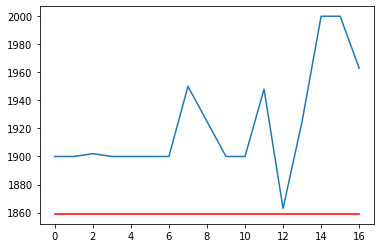

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   47
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -233.302
Method:                       css-mle   S.D. of innovations             33.747
Date:                Sun, 28 Jun 2020   AIC                            474.605
Time:                        11:07:17   BIC                            482.006
Sample:                             1   HQIC                           477.390
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.867      0.005      0.996      -1.695       1.704
ar.L1.D.y      0.6309      0.128      4.925      0.000       0.380       0.882
ma.L1.D.y     -0.9999      0.082    -12.218      0.0

In [51]:
#ARIMA model

X_rima_1br = agw_1br[['Sunnyside']].values
size_1br = int(len(X_rima_1br) * 0.75)
train_rima_1br, test_rima_1br = X_rima_1br[0:size], X_rima_1br[size:len(X_rima_1br)]
history_rima_1br = [x for x in train_rima_1br]
predictions_rima_1br = list()
for t in range(len(test_rima_1br)):
    model_1br = ARIMA(history_rima_1br, order=(1,1,1))
    model_fit_1br = model_1br.fit(disp=0)
    output = model_fit_1br.forecast()
    yhat = output[0]
    predictions_rima_1br.append(yhat)
    obs = test_rima_1br[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error_1br = mean_squared_error(test_rima_1br, predictions_rima_1br)
print('Test RMSE: %.3f' % sqrt(error_1br))
# plot
plt.plot(test_rima_1br)
plt.plot(predictions_rima_1br, color='red')
plt.show()
print(model_fit_1br.summary())

## FB PROPHET

In [62]:
fb_sunny_1br = sunny_1br

In [65]:
fb_sunny_1br.reset_index(inplace=True)
fb_sunny_1br.index.rename('', inplace=True)
fb_sunny_1br.rename(columns={'index': 'ds', 'Sunnyside': 'y'}, inplace=True)

In [64]:
fb_sunny_1br.head(1)

areaName,,ds,y
,,,
0,0,2015-01-01,1800


In [66]:
# Train/Split

X_a_1br = fb_sunny_1br['ds'].values
y_a_1br = fb_sunny_1br['y'].values

X_train_1br = X_a_1br[:int(X_a_1br.shape[0]*0.75)]
X_test_1br = X_a_1br[int(X_a_1br.shape[0]*0.75):]
y_train_1br = y_a_1br[:int(X_a_1br.shape[0]*0.75)]
y_test_1br = y_a_1br[int(X_a_1br.shape[0]*0.75):]

sun_1br_train = pd.DataFrame(y_train_1br,index = X_train_1br, columns = ['y'])
sun_1br_test = pd.DataFrame(y_test_1br, index = X_test_1br, columns = ['y'])
sun_1br_train.head()
sun_1br_train.reset_index(inplace = True)
sun_1br_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  99.22136989895465


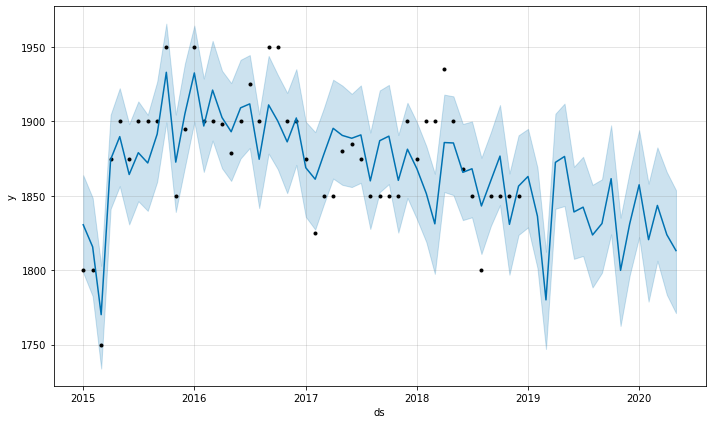

In [67]:
sun_1br_prophet = Prophet().fit(sun_1br_train)

future_sun_1br = sun_1br_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_sun_1br = sun_1br_prophet.predict(future_sun_1br)
forecast_sun_1br.tail()

fig1_sun_1br = sun_1br_prophet.plot(forecast_sun_1br)

preds_sun_1br = forecast_sun_1br[48:][['ds','yhat']].set_index('ds')
preds_sun_1br.head()

preds_sun_1br_df = pd.concat([sun_1br_test ,preds_sun_1br],axis = 1)
preds_sun_1br_df.head()

error_prophet_1br = np.sqrt(sum((preds_sun_1br_df['y'] - preds_sun_1br_df['yhat'])**2)/len(preds_sun_1br_df))
print('RMSE in $$: ', error_prophet_1br)


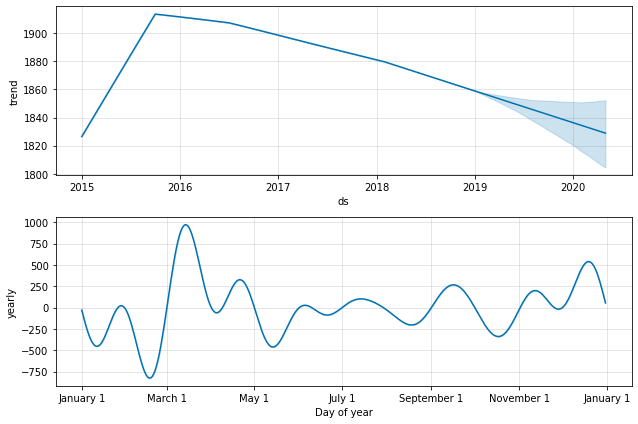

In [68]:
fig2_sun_1br = sun_1br_prophet.plot_components(forecast_sun_1br)

###  Three Bedroom Aparments + 

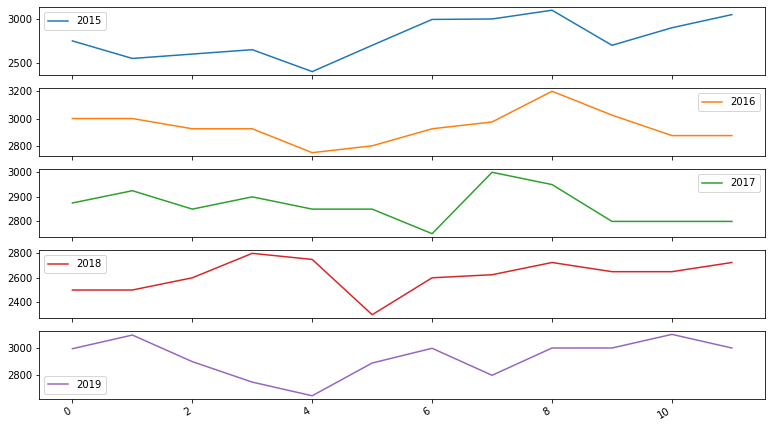

In [69]:
# Use pandas grouper to group values using annual frequency
year_groups_s_3br = agw_3br['2015':'2019'][['Sunnyside']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
annual_s_3br = pd.DataFrame()

for yr, group in year_groups_s_3br:
    annual_s_3br[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
annual_s_3br.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#annual_a_3br.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [72]:
roll_mean_s_3br = agw_3br[['Sunnyside']].rolling(window=8, center=False).mean()
roll_std_s_3br = agw_3br[['Sunnyside']].rolling(window=8, center=False).std()

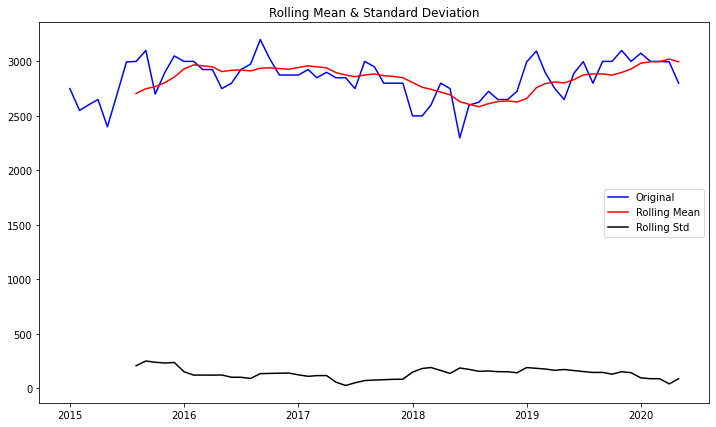

In [73]:
fig_roll_3br = plt.figure(figsize=(12,7))
plt.plot(agw_3br[['Sunnyside']], color='blue', label='Original')
plt.plot(roll_mean_s_3br, color='red', label='Rolling Mean')
plt.plot(roll_std_s_3br, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [74]:
#dickeyfuller test for Astoria Studios

dftest_s_3br = adfuller(agw_3br[['Sunnyside']])

# Extract and display test results in a user friendly manner
dfoutput_s_3br = pd.Series(dftest_s_3br[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_s_3br[4].items():
    dfoutput_s_3br['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_s_3br)

Results of Dickey-Fuller test: 

Test Statistic                 -3.815610
p-value                         0.002752
#Lags Used                      0.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


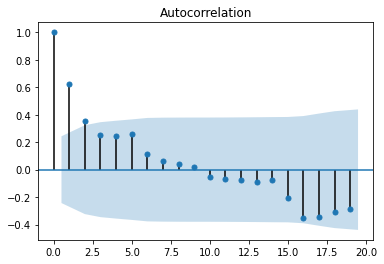

In [75]:
plot_acf(agw_3br['Sunnyside']);

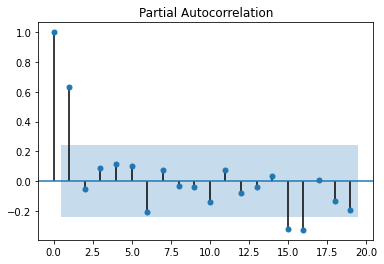

In [76]:
plot_pacf(agw_3br['Sunnyside']);

### BASELINE MODEL

In [79]:
sun_3br = agw_3br[['Sunnyside']]

In [80]:
# Create lagged dataset
values_3br = pd.DataFrame(sun_3br.values)
dataframe_3br = pd.concat([values_3br.shift(1), values_3br], axis=1)
dataframe_3br.columns = ['t-1', 't+1']
print(dataframe_3br.head(5))

    t-1   t+1
0   NaN  2750
1  2750  2550
2  2550  2600
3  2600  2650
4  2650  2400


In [81]:
# split into train and test sets
X_3br = dataframe_3br.values
train_size_3br = int(len(X_3br) * 0.75)
train_3br, test_3br = X_3br[1:train_size_3br], X_3br[train_size_3br:]
train_X_3br, train_y_3br = train_3br[:,0], train_3br[:,1]
test_X_3br, test_y_3br = test_3br[:,0], test_3br[:,1]

In [82]:
#model persistence defined above in studios

# walk-forward validation
predictions_3br = list()
for x in test_X_3br:
    yhat_3br = model_persistence(x)
    predictions_3br.append(yhat_3br)
test_score_3br = mean_squared_error(test_y_3br, predictions_3br)
print('Test RMSE: %.3f' % sqrt(test_score_3br))

Test RMSE: 147.766


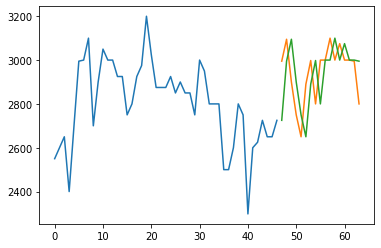

In [83]:
# plot predictions and expected results
plt.plot(train_y_3br)
plt.plot([None for i in train_y_3br] + [x for x in test_y_3br])
plt.plot([None for i in train_y_3br] + [x for x in predictions_3br])
plt.show()

### ARIMA MODEL

predicted=2731.474045, expected=2995.000000
predicted=2731.474045, expected=3095.000000
predicted=2731.474045, expected=2900.000000
predicted=2731.474045, expected=2750.000000
predicted=2731.474045, expected=2650.000000
predicted=2731.474045, expected=2890.000000
predicted=2731.474045, expected=2998.000000
predicted=2731.474045, expected=2800.000000
predicted=2731.474045, expected=3000.000000
predicted=2731.474045, expected=3000.000000
predicted=2731.474045, expected=3100.000000
predicted=2731.474045, expected=3000.000000
predicted=2731.474045, expected=3075.000000
predicted=2731.474045, expected=3000.000000
predicted=2731.474045, expected=3000.000000
predicted=2731.474045, expected=2995.000000
predicted=2731.474045, expected=2800.000000
Test RMSE: 245.709


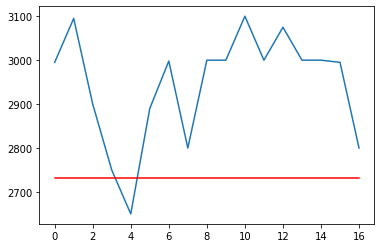

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   48
Model:                     ARMA(2, 1)   Log Likelihood                -307.073
Method:                       css-mle   S.D. of innovations            144.499
Date:                Sun, 28 Jun 2020   AIC                            624.146
Time:                        11:17:06   BIC                            633.502
Sample:                             0   HQIC                           627.681
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2786.2266     67.414     41.330      0.000    2654.097    2918.356
ar.L1.y        1.2628      0.351      3.599      0.000       0.575       1.950
ar.L2.y       -0.3497      0.256     -1.364      0.1

In [91]:
#ARIMA model

X_rima_3br = agw_3br[['Sunnyside']].values
size_3br = int(len(X_rima_3br) * 0.75)
train_rima_3br, test_rima_3br = X_rima_3br[0:size], X_rima_3br[size:len(X_rima_3br)]
history_rima_3br = [x for x in train_rima_3br]
predictions_rima_3br = list()
for t in range(len(test_rima_3br)):
    model_3br = ARIMA(history_rima_3br, order=(2,0,1))
    model_fit_3br = model_3br.fit(disp=0)
    output = model_fit_3br.forecast()
    yhat = output[0]
    predictions_rima_3br.append(yhat)
    obs = test_rima_3br[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error_3br = mean_squared_error(test_rima_3br, predictions_rima_3br)
print('Test RMSE: %.3f' % sqrt(error_3br))
# plot
plt.plot(test_rima_3br)
plt.plot(predictions_rima_3br, color='red')
plt.show()
print(model_fit_3br.summary())

## FB PROPHET

In [93]:
fb_sun_3br = sun_3br

In [94]:
fb_sun_3br.reset_index(inplace=True)
fb_sun_3br.index.rename('', inplace=True)
fb_sun_3br.rename(columns={'index': 'ds', 'Sunnyside': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [95]:
fb_sun_3br.head(1)

areaName,ds,y
,,
0,2015-01-01,2750


In [96]:
# Train/Split

X_s_3br = fb_sun_3br['ds'].values
y_s_3br = fb_sun_3br['y'].values

X_train_3br = X_s_3br[:int(X_s_3br.shape[0]*0.75)]
X_test_3br = X_s_3br[int(X_s_3br.shape[0]*0.75):]
y_train_3br = y_s_3br[:int(X_s_3br.shape[0]*0.75)]
y_test_3br = y_s_3br[int(X_s_3br.shape[0]*0.75):]

s_3br_train = pd.DataFrame(y_train_3br,index = X_train_3br, columns = ['y'])
s_3br_test = pd.DataFrame(y_test_3br, index = X_test_3br, columns = ['y'])
s_3br_train.head()
s_3br_train.reset_index(inplace = True)
s_3br_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  172.16958428427992


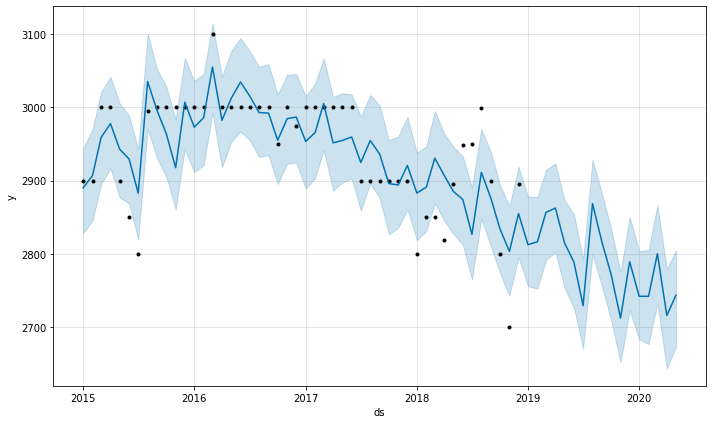

In [120]:
s_3br_prophet = Prophet().fit(s_3br_train)

future_s_3br = s_3br_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_s_3br = s_3br_prophet.predict(future_s_3br)
forecast_s_3br.tail()

fig1_s_3br = ast_3br_prophet.plot(forecast_ast_3br)

preds_ast_3br = forecast_ast_3br[48:][['ds','yhat']].set_index('ds')
preds_ast_3br.head()

preds_ast_3br_df = pd.concat([ast_3br_test ,preds_ast_3br],axis = 1)
preds_ast_3br_df.head()

error_prophet_3br = np.sqrt(sum((preds_ast_3br_df['y'] - preds_ast_3br_df['yhat'])**2)/len(preds_ast_3br_df))
print('RMSE in $$: ', error_prophet_3br)


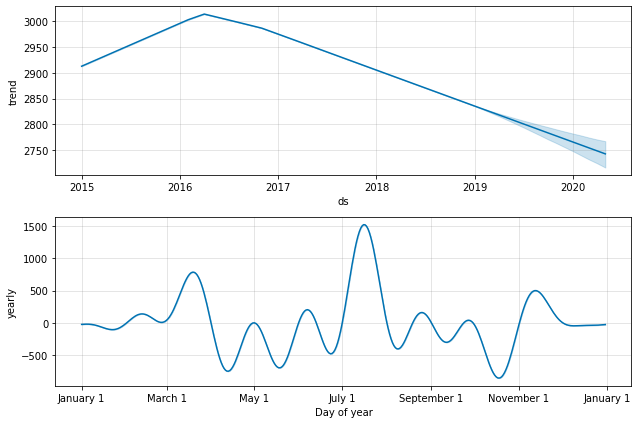

In [121]:
fig3_ast_3br = ast_3br_prophet.plot_components(forecast_ast_3br)